# How Autoencoders work - Understanding the math and implementation by Shivam Bansal_2

**[Building Autoencoders in Keras](https://keraskorea.github.io/posts/2018-10-23-keras_autoencoder/) 참고**          

**autodencoder는 무엇일까요?**
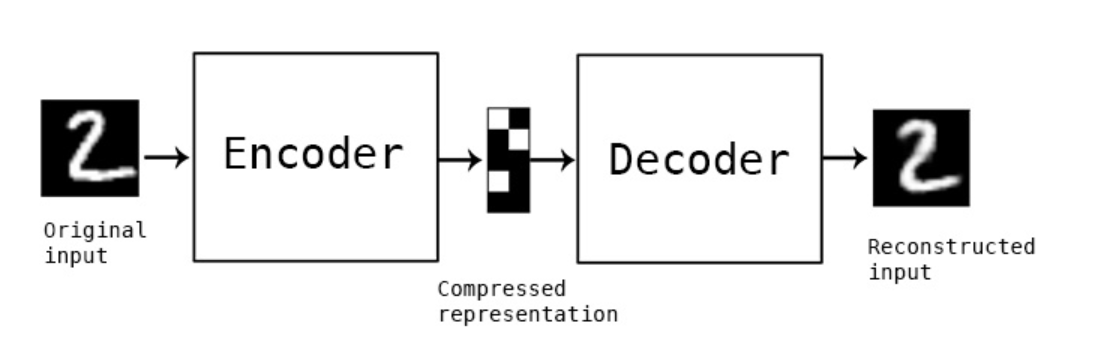    
`Autoencoding`은 데이터 압축 알고리즘으로 압축 함수와 압축 해제 함수는 다음과 같은 세가지 특징을 같습니다. 
1. **data-specific** : 오토인코더는 이제껏 훈련된 데이터와 비슷한 데이터로만 압축될 수 있습니다. 예를 들어 말하자면, 오토인코더는 MPEG-2 Audio Layer 3(MP3) 압축 알고리즘과는 다릅니다. MP3 알고리즘은 일반적으로 소리에 관한 압축이지만 특정한 종류의 소리에 관한 것은 아닙니다. 얼굴 사진에 대해 학습된 오토인코더는 나무의 사진을 압축하는 데에는 좋은 성능을 내지 못하는데 그 이유는 오토인코더가 배우는 특징은 _얼굴특유의 것_ 이기 때문입니다.
2. **손실이 있습니다** : 즉, 압축 해제된 결과물은 원본 보다 좋지 않습니다. (ex.MP3, JPEG 압축). 이는 손실없는 산술 압축과는 다릅니다.
3. **오토인코더는 예제 데이터로부터 자동적으로 학습합니다** : 이는 유용한 성질입니다. 데이터로부터 자동적으로 학습한다는 의미는 특정 종류의 입력값에 대해 잘 작동하는 특정한 형태의 알고리즘을 쉽게 훈련시킬 수 있다는 말입니다. 이는 새로운 공학적 방법 필요 없이 단지 데이터를 적절히 훈련시키면 됩니다.     

오토인코더를 만들기 위해서는 세 가지가 필요합니다. 
* 인코딩 함수 (encoding function)
* 디코딩 함수 (decoding function)
* 원본에 대해 압축된 표현(representation)과 압축 해제된 표현(representation) 간 정보 손실량 간의 거리 함수, 즉 손실 함수   

인코더와 디코더는 parametic 함수(일반적으로 신경망)로 선택되고 거리 함수와 관련하여 차별화되므로 인코딩/디코딩 함수의 매개변수를 `확률적 경사하강법(Stochastic gradient descent)`을 사용하여 재구성 손실을 최소화하도록 최적화 할 수 있습니다.

**autoencoder는 데이터 압축에 좋을까요?**    
일반적으로는 그렇지 않습니다.

**autoencoder는 어디에 쓰일까요?**
autoencoder는 실제 응용에서는 거의 사용되지 않습니다.

# Implementation

## UseCase 1 : Image Reconstruction

1. Load the required libararies

In [1]:
# Load libraries 
from tensorflow.keras.layers import Dense, Input, Conv2D,LSTM,MaxPool2D,UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Model 

from sklearn.model_selection import train_test_split 
from imgaug import augmenters 
from random import randint 
from numpy import argmax, array_equal

import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt 

2. Dataset Preparation

In [16]:
# Read  dataset
train = pd.read_csv('data/fashion-mnist_train.csv')
train_x = train[list(train.columns)[1:]].values 
train_y = train['label'].values 

In [17]:
len(train[train.columns[1:]].values)

60000

In [18]:
train.shape

(60000, 785)

In [19]:
# normalize and reshape the predictors 
# Q.왜 255로 나누지? 255 = 픽셀값
train_x = train_x / 255 

# create train and validation datasets 
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y,test_size = 0.2)

#reshape 
train_x = train_x.reshape(-1,784)
val_x = val_x.reshape(-1,784)

3. Create Autoencoder architecture 

In [20]:
# Input layer 
input_layer = Input(shape=(784,))

# encoding architecture 
encode_layer1 = Dense(1500, activation='relu')(input_layer)
encode_layer2 = Dense(1000, activation='relu')(encode_layer1)
encode_layer3 = Dense(500, activation='relu')(encode_layer2)

# latent view
latent_view = Dense(10, activation='sigmoid')(encode_layer3)

# decoding architecture
decode_layer1 = Dense(500, activation='relu')(latent_view)
decode_layer2 = Dense(1000, activation='relu')(decode_layer1)
decode_layer3 = Dense(1500, activation='relu')(decode_layer2)

# output layer 
output_layer = Dense(784)(decode_layer3)

model = Model(input_layer, output_layer)

In [21]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 1500)              1177500   
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1501000   
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5010      
_________________________________________________________________
dense_4 (Dense)              (None, 500)               5500      
_________________________________________________________________
dense_5 (Dense)              (None, 1000)             

In [22]:
# early stopping callback
model.compile(optimizer='adam',loss='mse')
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=10,verbose=1,mode='auto')
model.fit(train_x, train_x, epochs=20, batch_size=2048,
         validation_data=(val_x,val_x),callbacks=[early_stopping])

Epoch 1/20
24/24 [==============================] - 10s 398ms/step - loss: 0.0974 - val_loss: 0.0728
Epoch 2/20
24/24 [==============================] - 11s 446ms/step - loss: 0.0658 - val_loss: 0.0559
Epoch 3/20
24/24 [==============================] - 11s 469ms/step - loss: 0.0496 - val_loss: 0.0422
Epoch 4/20
24/24 [==============================] - 11s 470ms/step - loss: 0.0399 - val_loss: 0.0380
Epoch 5/20
24/24 [==============================] - 13s 531ms/step - loss: 0.0357 - val_loss: 0.0340
Epoch 6/20
24/24 [==============================] - 14s 568ms/step - loss: 0.0326 - val_loss: 0.0338
Epoch 7/20
24/24 [==============================] - 13s 556ms/step - loss: 0.0307 - val_loss: 0.0289
Epoch 8/20
24/24 [==============================] - 13s 561ms/step - loss: 0.0278 - val_loss: 0.0278
Epoch 9/20
24/24 [==============================] - 13s 555ms/step - loss: 0.0258 - val_loss: 0.0249
Epoch 10/20
24/24 [==============================] - 13s 559ms/step - loss: 0.0245 - val_lo

In [24]:
# Generate the predictions on validation data
preds = model.predict(val_x)

Lets plot the original and predicted image

**Inputs : Actual Images**

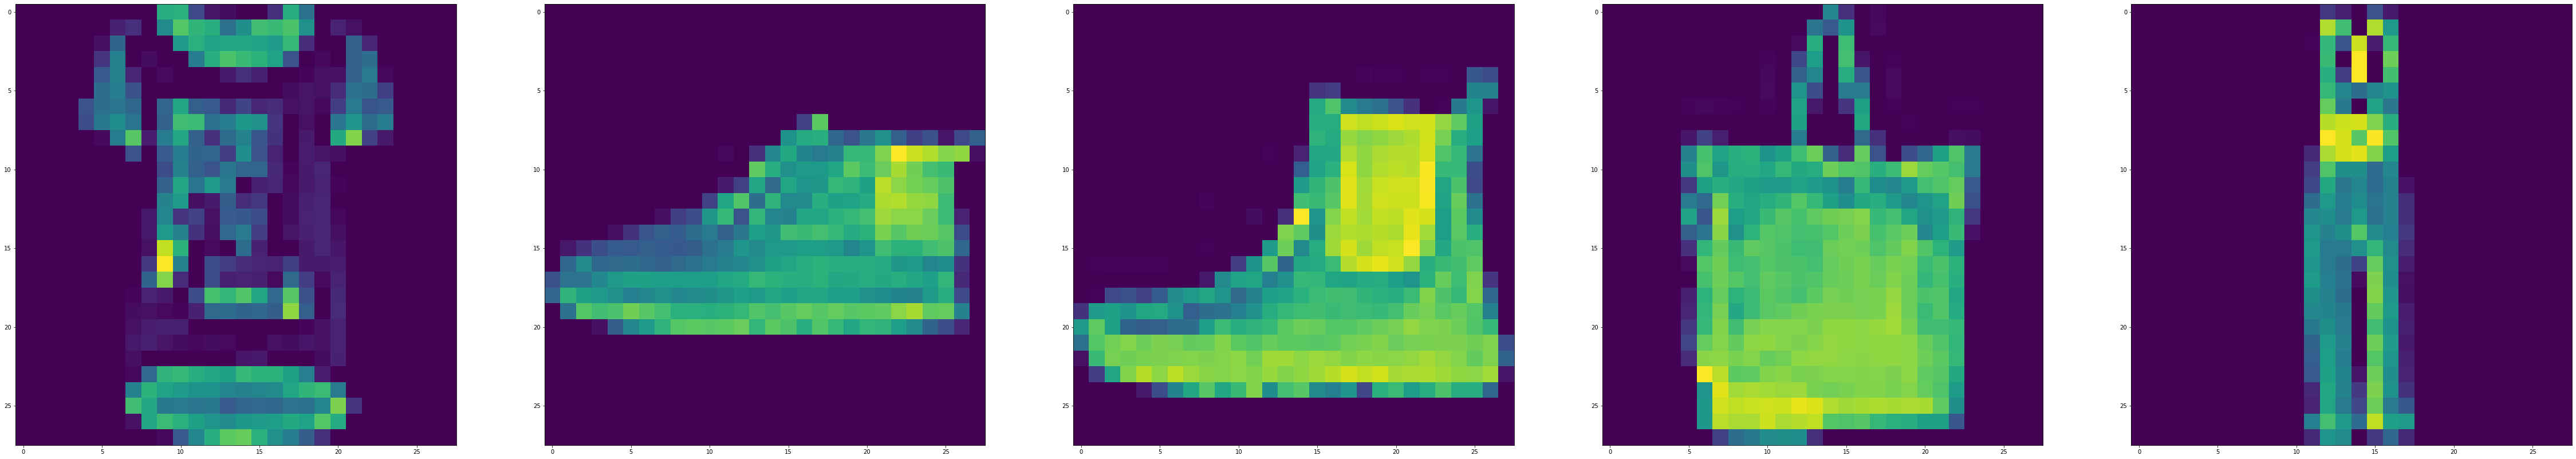

In [25]:
from PIL import Image 
f, ax = plt.subplots(1,5)
f.set_size_inches(80,40)
for i in range(5) :
    ax[i].imshow(val_x[i].reshape(28,28))
plt.show()

**Predicted : Autoencoder Output**

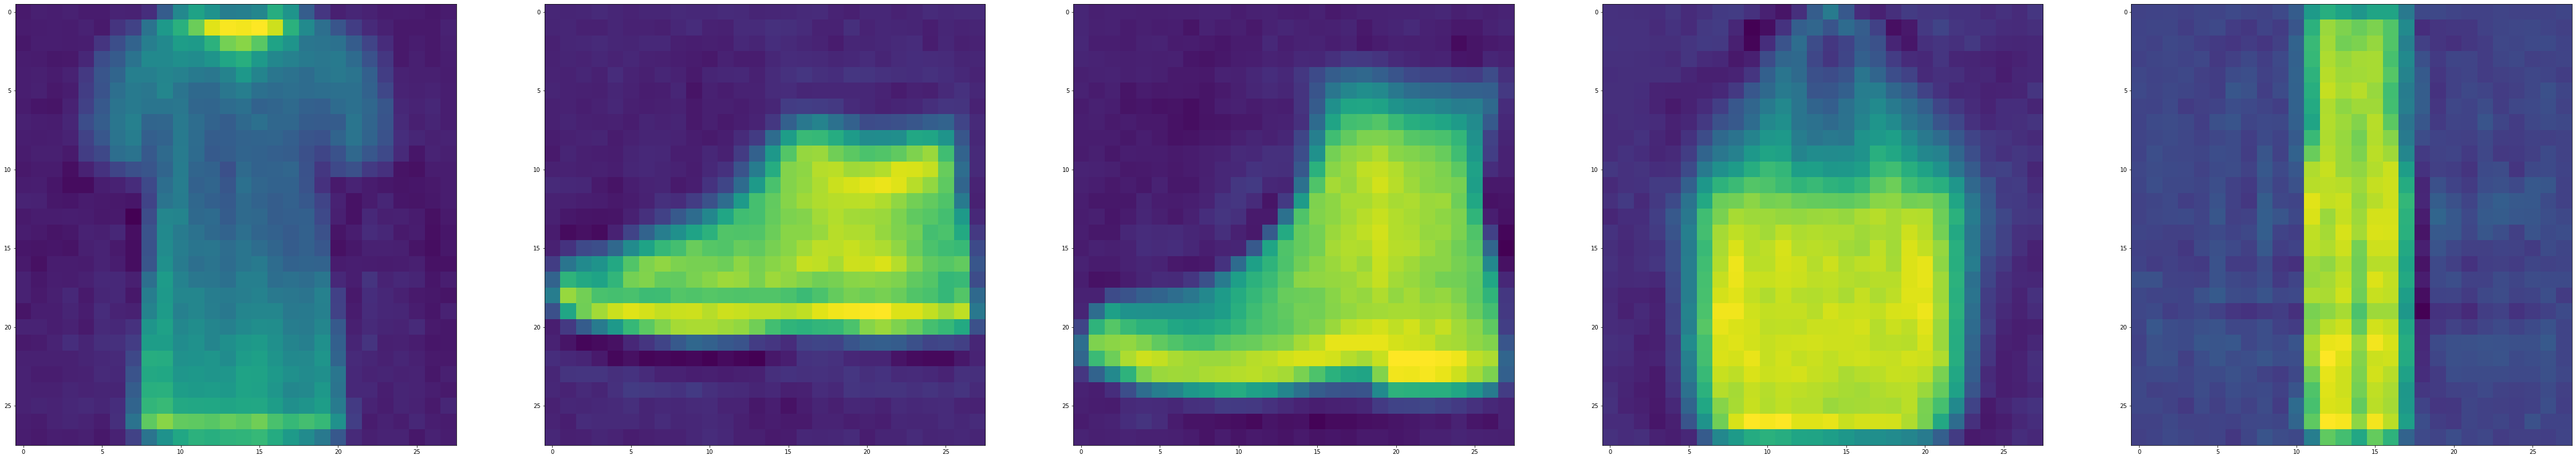

In [26]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80,40)
for i in range(5) :
    ax[i].imshow(preds[i].reshape(28,28))
plt.show()

## UseCase 2 - Image Denoising 
이제 우리의 convolution autoencoder를 이미지 denoising 문제에 적용해봅시다. 매우 간단합니다. : 노이즈(noisy)한 숫자 이미지를 클린(clean)한 숫자 이미지로 매핑하는 autoencoder를 훈련시키면 됩니다.       

아래 합성 노이즈가 있는 숫자를 생성하는 방법입니다. 가우스 노이즈 행렬을 적용하여 이미지를 0과 1사이에서 잘라내면 됩니다. 

In [27]:
# recreate the train_x array and val_x array
train_x = train[list(train.columns)[1:]].values 
train_x, val_x =train_test_split(train_x, test_size = 0.2)

## normalize and reshape 
train_x = train_x / 255 
val_x = val_x /255 

이전에 convolutional autoencoder와 비교해서, 재구성된 이미지의 질을 향상시키려며나, 약간 다른 모델을 사용하여 layer당 더 많은 필터를 사용합니다.     
* shape(28,28,1) -> channels_first 이미지 데이터 형식을 사용하는 경우 적용

In [28]:
train_x = train_x.reshape(-1, 28,28,1)
val_x = val_x.reshape(-1,28,28,1)

train_x.shape 

(48000, 28, 28, 1)

**Noisy Images**
[노이즈에 대한 블로그글](https://m.blog.naver.com/PostView.nhn?blogId=laonple&logNo=220811027599&proxyReferer=https:%2F%2Fwww.google.com%2F)     
1. Gaussian Noise : 정규 분포를 갖는 Noise로 일반적인 Noise라 할 수 있습니다. 어느 정도 무작위로 발생하면서 일반적으로 쉽게 볼 수 있는 분포를 갖고 있습니다.  
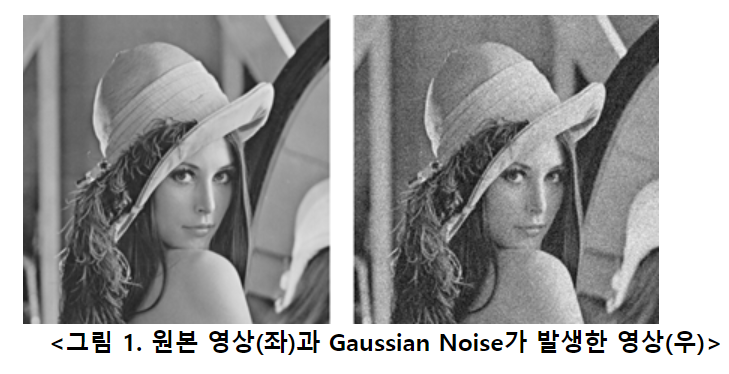

2. Salt-and-pepper-Noise : Impulse Noise에 포한된 Noise입니다. `Impulse Noise`란 0 또는 255 픽셀 값과 같이 뚜렷하게 잘못된 밝기 값을 갖는 Noise를 말합니다. salt-and-pepper- Noise 라는 말 그대로 소금-후추로 검은색 또는 흰색 점의 형태로 발생하는 Noise를 뜻합니다.        
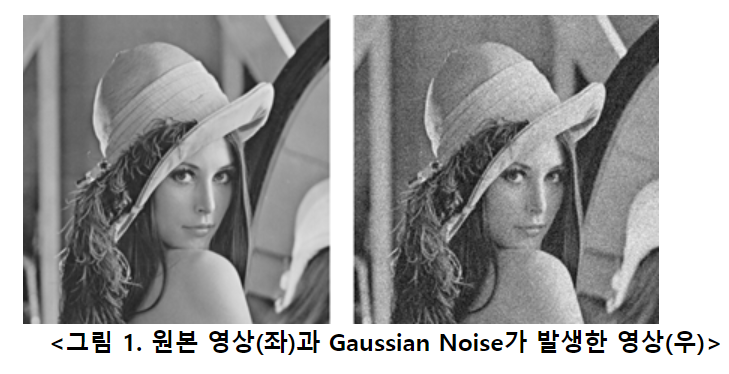

2. Salt-and-pepper-Noise : Impulse Noise에 포한된 Noise입니다. `Impulse Noise`란 0 또는 255 픽셀 값과 같이 뚜렷하게 잘못된 밝기 값을 갖는 Noise를 말합니다. salt-and-pepper- Noise 라는 말 그대로 소금-후추로 검은색 또는 흰색 점의 형태로 발생하는 Noise를 뜻합니다.        
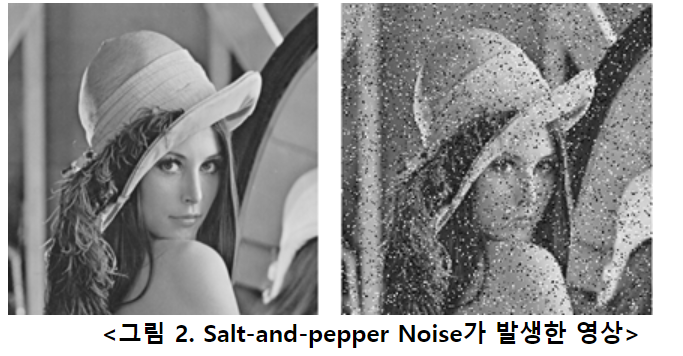

3. Uniform Noise : 균일한 분포를 갖는 Noise를 말합니다. 영상의 전체 영역에 대해서 같은 패턴을 갖는 Noise가 일정하게 발생합니다. 
  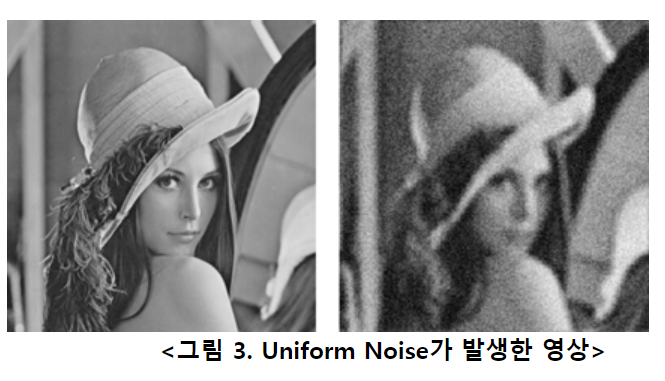

In [29]:
# Let's add sample noise - Salt and Pepper 
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(train_x * 255) / 255 
val_x_n = seq_object.augment_images(val_x * 255) /255

Before adding noise 

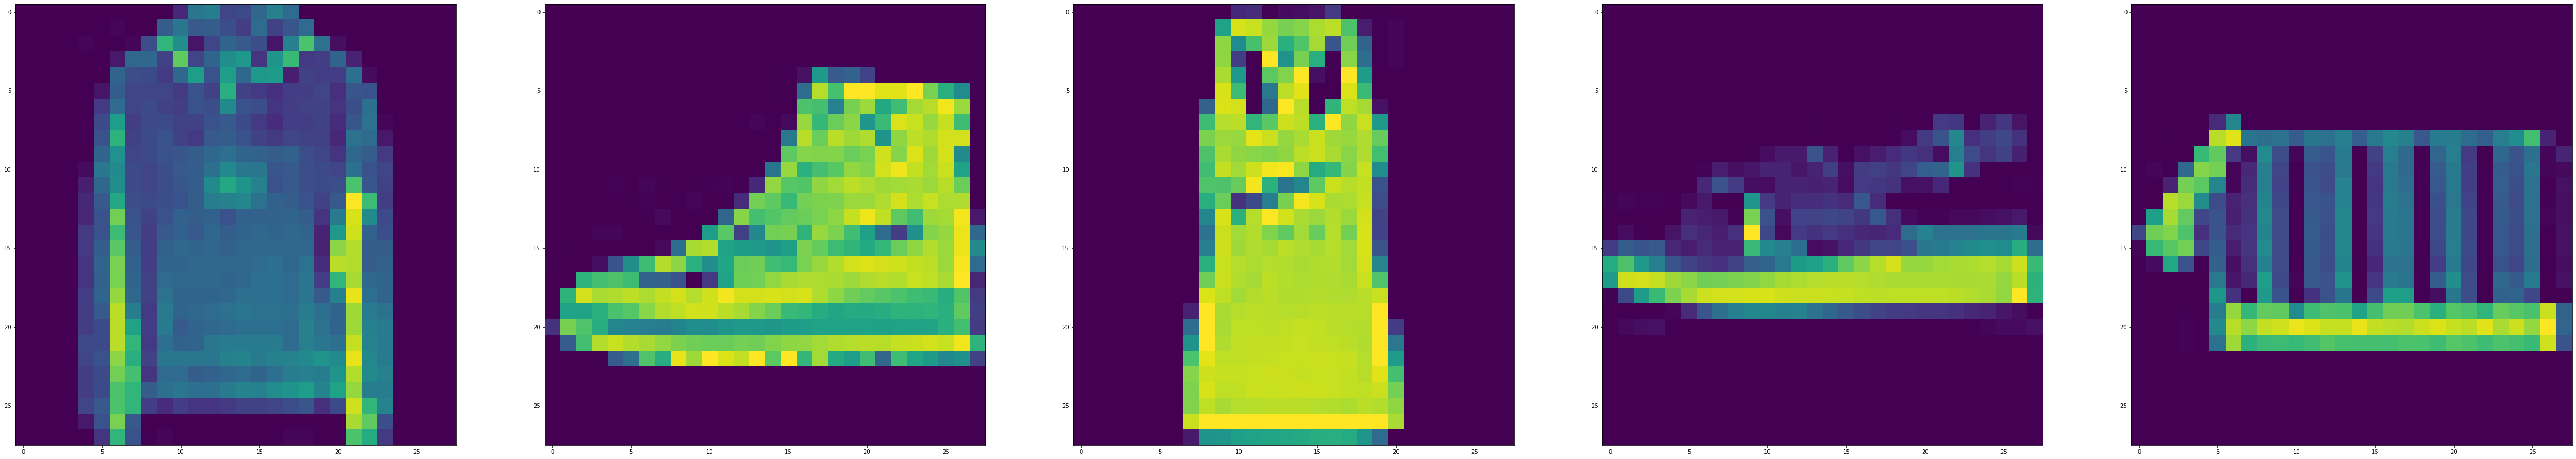

In [30]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80,40)
for i in range(5,10) :
    ax[i-5].imshow(train_x[i].reshape(28,28))
plt.show()

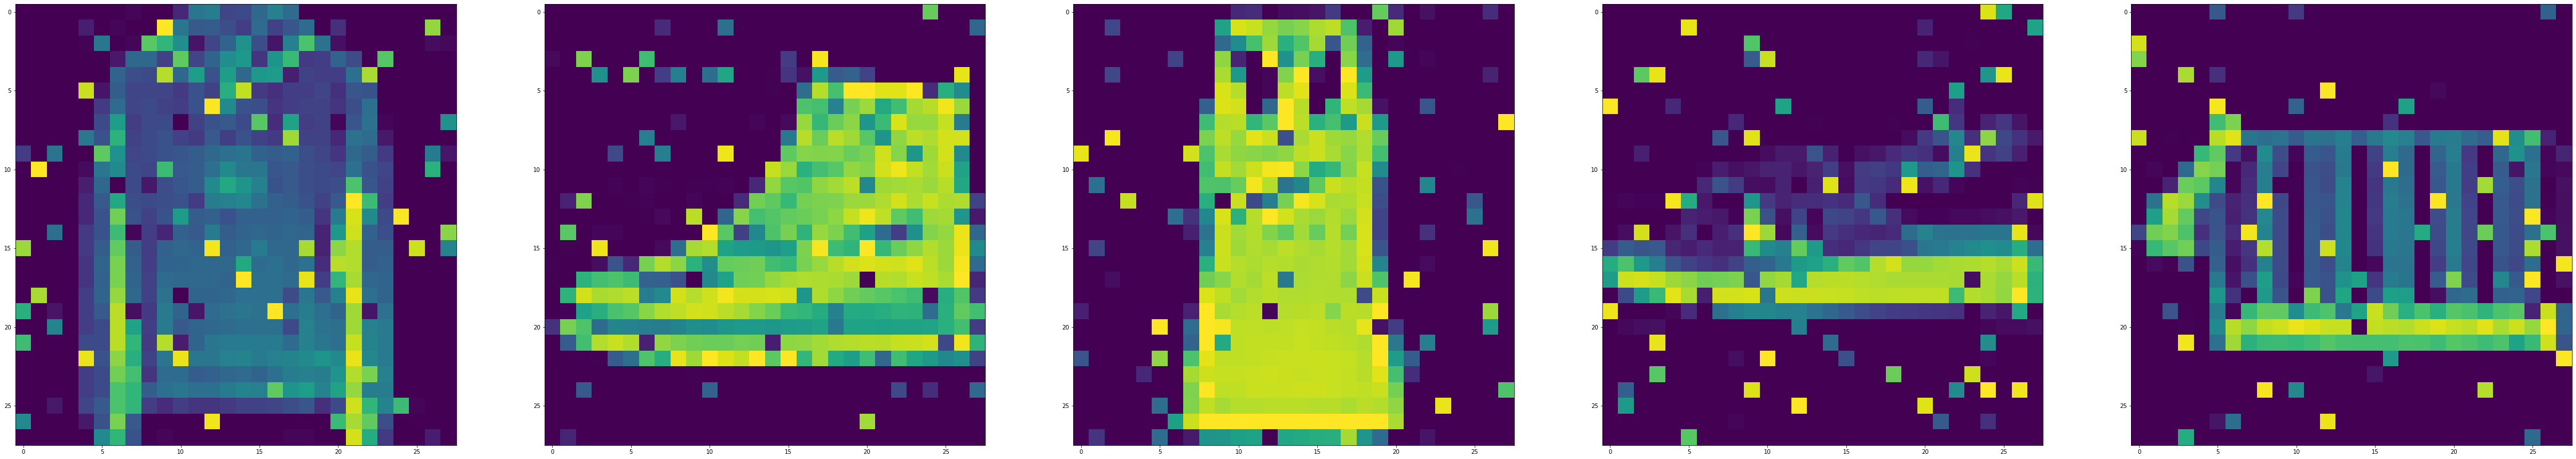

In [31]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80,40)
for i in range(5,10) :
    ax[i-5].imshow(train_x_n[i].reshape(28,28))
plt.show()

In [39]:
# input layer
input_layer = Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

# compile the model
model_2 = Model(input_layer, output_layer)
model_2.compile(optimizer='adam', loss='mse')

In [40]:
model_2.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 4, 4, 16)         

In [41]:
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=10,
                              verbose=5,mode='auto')
history = model_2.fit(train_x_n, train_x,epochs=10,batch_size=2048,
                     validation_data=(val_x_n,val_x),callbacks=[early_stopping])

Epoch 1/10
24/24 [==============================] - 102s 4s/step - loss: 0.0906 - val_loss: 0.0513
Epoch 2/10
24/24 [==============================] - 109s 5s/step - loss: 0.0436 - val_loss: 0.0374
Epoch 3/10
24/24 [==============================] - 110s 5s/step - loss: 0.0343 - val_loss: 0.0312
Epoch 4/10
24/24 [==============================] - 110s 5s/step - loss: 0.0292 - val_loss: 0.0272
Epoch 5/10
24/24 [==============================] - 1141s 48s/step - loss: 0.0259 - val_loss: 0.0245
Epoch 6/10
24/24 [==============================] - 108s 5s/step - loss: 0.0236 - val_loss: 0.0227
Epoch 7/10
24/24 [==============================] - 110s 5s/step - loss: 0.0223 - val_loss: 0.0218
Epoch 8/10
24/24 [==============================] - 110s 5s/step - loss: 0.0212 - val_loss: 0.0208
Epoch 9/10
24/24 [==============================] - 1313s 55s/step - loss: 0.0204 - val_loss: 0.0202
Epoch 10/10
24/24 [==============================] - 115s 5s/step - loss: 0.0199 - val_loss: 0.0196


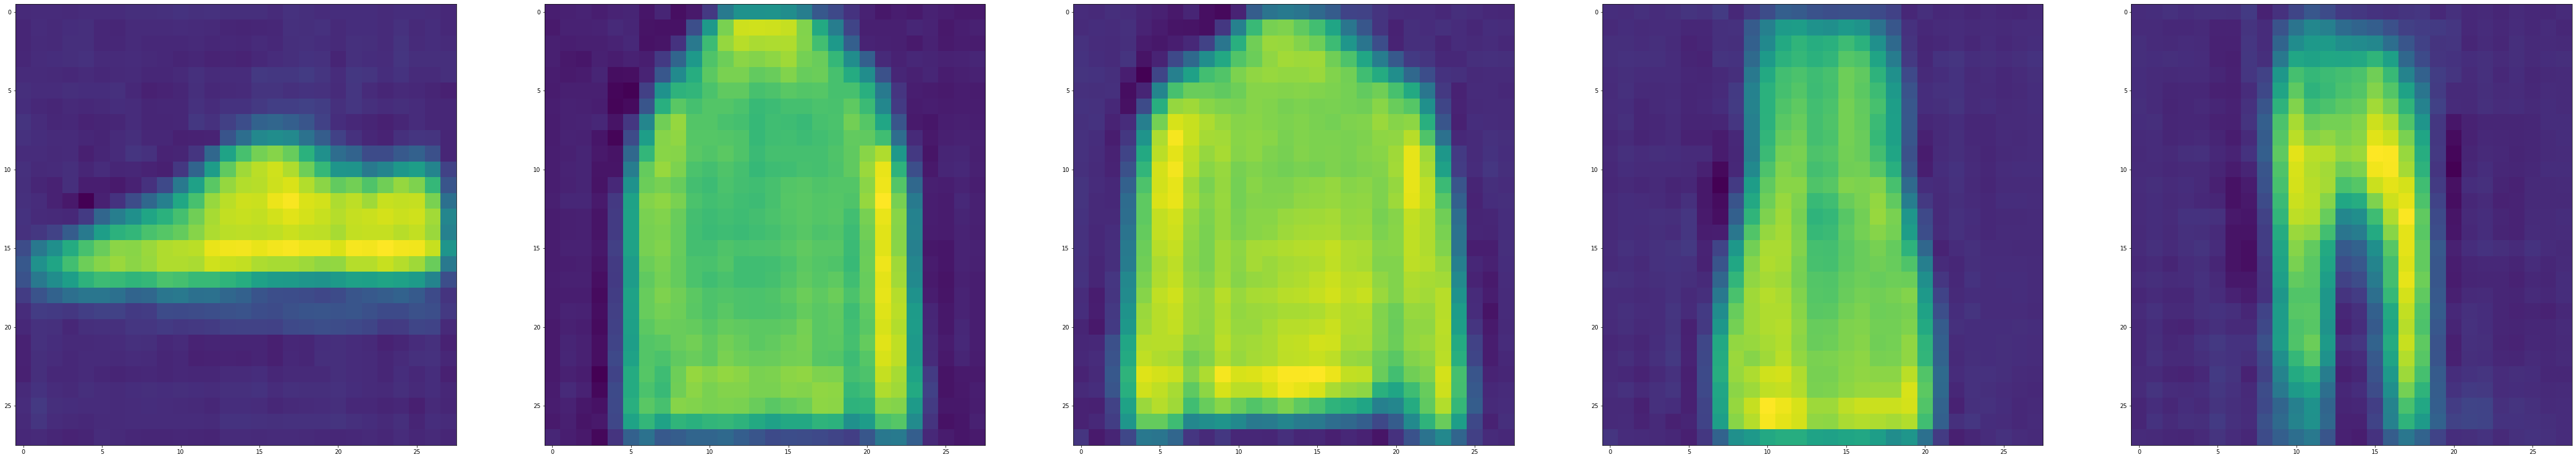

In [42]:
preds =model_2.predict(val_x_n[:10])
f,ax = plt.subplots(1,5)
f.set_size_inches(80,40)
for i in range(5,10) :
    ax[i-5].imshow(preds[i].reshape(28,28))
plt.show()

## UseCase 3: Sequence Prediction using AutoEncoders
벡터나 2D 이미지가 아닌 입력값이 연속적이라면, 인코더와 디코더를 시간 구조를 잡을 수 있는 모델을 사용하고 싶을 것입니다. LSTM 같은 것 말이죠. LSTM 기반의 autoencoder를 만들기 위해서는, 먼저 LSTM 인코더를 사용하여 입력 시퀀스를 전체 시퀀스에 대한 정보가 들어있는 단일 벡터로 변환하고, 그 벡터를 n번 반복합니다.(n은 출력 시퀀스의 timestep의 수입니다.) 그리고 이 일정한 시퀀스를 타겟 시퀀스로 바꾸기 위해 LSTM 디코더를 실행합니다.

In [52]:
def dataset_preparation(n_in, n_out, n_unique, n_samples) :
    X1, X2,y =[],[],[]
    # 랜덤 숫자 시퀀스 만들기 - 입력
    for _ in range(n_samples) :
        inp_seq = [randint(1, n_unique-1) for _ in range(n_in)]   
        #타겟 시퀀스 만들기
        target = inp_seq[:n_out] 

        # padded sequence / seed sequence 만들기
        target_seq = list(reversed(target))
        seed_seq = [0] + target_seq[:-1]

        # 요소를 카테고리컬 로 바꾸기
        X1.append(to_categorical([inp_seq],num_classes=n_unique))
        X2.append(to_categorical([seed_seq],num_classes=n_unique))
        y.append(to_categorical([target_seq],num_classes=n_unique))
    
    # 불필요한 차원 지우기
    # squeeze는 차원 중 사이즈가 1인것을 찾아 스칼라값으로 바꿔
    # 해당 차원을 제거
    X1 =np.squeeze(np.array(X1), axis = 1)
    X2 =np.squeeze(np.array(X2), axis = 1)
    y =np.squeeze(np.array(y), axis = 1)
    
    return X1, X2, y 

In [53]:
samples = 100000
features = 51 
inp_size = 6
out_size = 3 

inputs, seeds, outputs = dataset_preparation(inp_size, out_size, features, samples)
print('Shape :',inputs.shape, seeds.shape, outputs.shape)
print ("Here is first categorically encoded input sequence looks like: ", )
inputs[0][0]

Shape : (100000, 6, 51) (100000, 3, 51) (100000, 3, 51)
Here is first categorically encoded input sequence looks like: 


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [73]:
def define_models(n_input, n_output):
    ## define the encoder architecture 
    ## input : sequence 
    ## output : encoder states 
    encoder_inputs = Input(shape=(None, n_input))
    encoder = LSTM(128, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]

    ## define the encoder-decoder architecture 
    ## input : a seed sequence 
    ## output : decoder states, decoded output 
    decoder_inputs = Input(shape=(None, n_output))
    decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(n_output, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    ## define the decoder model
    ## input : current states + encoded sequence
    ## output : decoded sequence
    encoder_model = Model(encoder_inputs, encoder_states)
    decoder_state_input_h = Input(shape=(128,))
    decoder_state_input_c = Input(shape=(128,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

    return model, encoder_model, decoder_model

autoencoder, encoder_model, decoder_model = define_models(features, features)

In [74]:
encoder_model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, None, 51)]        0         
_________________________________________________________________
lstm (LSTM)                  [(None, 128), (None, 128) 92160     
Total params: 92,160
Trainable params: 92,160
Non-trainable params: 0
_________________________________________________________________


In [75]:
decoder_model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, 51)]   0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 128),  92160       input_9[0][0]                    
                                                                 input_10[0][0]       

In [76]:
autoencoder.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, None, 51)]   0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, None, 51)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 128), (None, 92160       input_8[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 128),  92160       input_9[0][0]                    
                                                                 lstm[0][1]            

In [77]:
autoencoder.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
autoencoder.fit([inputs, seeds],outputs, epochs=1)

3125/3125 [==============================] - 24s 8ms/step - loss: 0.6466 - acc: 0.7954


인풋 시퀀스에 기초해 시퀀스를 예측하는 함수를 만들어보자

In [80]:
def reverse_onehot(encoded_seq) :
    return [argmax(vector) for vector in encoded_seq]

def predict_sequence(encoder, decoder, sequence) :
    output= [] 
    target_seq = np.array([0.0 for _ in range(features)])
    target_seq = target_seq.reshape(1,1, features)
    current_state = encoder.predict(sequence)
    
    for t in range(out_size) :
        pred, h, c = decoder.predict([target_seq]+current_state)
        output.append(pred[0,0,:])
        current_state = [h,c]
        target_seq = pred 
    return np.array(output)

In [81]:
# Q. X는 인풋값 , target이 정답 그렇다면 y는...? seeds_sequence가 뭐여?
for k in range(5) :
    X1, X2, y = dataset_preparation(inp_size,out_size,features,1)
    target = predict_sequence(encoder_model, decoder_model,X1)
    print('\nInput Sequence=%s SeedSequence=%s, PredictedSequence=%s' 
          % (reverse_onehot(X1[0]), reverse_onehot(y[0]), reverse_onehot(target)))


Input Sequence=[40, 31, 18, 43, 17, 21] SeedSequence=[18, 31, 40], PredictedSequence=[18, 31, 40]

Input Sequence=[34, 20, 7, 7, 18, 33] SeedSequence=[7, 20, 34], PredictedSequence=[7, 20, 34]

Input Sequence=[16, 44, 42, 4, 6, 40] SeedSequence=[42, 44, 16], PredictedSequence=[42, 44, 16]

Input Sequence=[3, 50, 11, 11, 38, 17] SeedSequence=[11, 50, 3], PredictedSequence=[11, 50, 3]

Input Sequence=[11, 20, 38, 20, 50, 2] SeedSequence=[38, 20, 11], PredictedSequence=[20, 20, 11]
